In [1]:
%pip install emcee
%pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from importlib import reload
import tqdm
import time
import emcee
from google.colab import files
from copy import deepcopy

**64**

In [3]:
def grad_log_pi(theta, beta): # gradient of log pi
  L = len(theta)
  grad = np.zeros(L)
  for i in range(L):
    grad[i] = -2*beta*(np.sin(theta[i]-theta[(i-1)%L])+np.sin(theta[i]-theta[(i+1)%L]))
  return grad # row vector (L,)

def new_theta(theta, beta, h): # generating new theta
  L = len(theta)
  # here S = identity, div(S) = 0
  xi = np.random.randint(0,2,L)*2-1
  theta += h*grad_log_pi(theta, beta)+np.sqrt(2*h)*xi
  theta  = (theta+np.pi)%(2*np.pi)-np.pi
  return theta

def q(y, x, h, beta): # probability for proposing x to y
  a = y-x-h*grad_log_pi(x, beta)
  ata = a.dot(a)
  return np.exp(-ata/(4*h))

def pi(theta, beta): # density pi(theta)
  sum_ij = 0
  L = len(theta)
  for i in range(len(theta)):
    sum_ij += (np.cos(theta[i]-theta[(i-1)%L])+np.cos(theta[i]-theta[(i+1)%L]))
  return np.exp(beta*sum_ij)

def metropolis(theta, theta_new, h, beta): # Metropolis
  p_acc = q(theta, theta_new, h, beta)*pi(theta_new, beta)/(q(theta_new, theta, h, beta)*pi(theta, beta))
  return np.random.random() < min(1, p_acc)  # if we accept the proposal

def OD_langevin(L, beta, h, metro = False): # (un)metropolized scheme for Overdamped Langevin
  step = int(divmod(500,h)[0])
  a_his = [] # store target functional
  theta = np.random.rand(L)*2*np.pi-np.pi # initialize the theta as row vector of length L
  for st in range(step):
    theta_new = new_theta(theta, beta, h)
    if metro: # with Metropolis
      if metropolis(theta, theta_new, h, beta):
        theta = theta_new
    else: # without Metropolis
      theta = theta_new
    a = np.sum(np.array([np.cos(theta), np.sin(theta)]), axis=1)
    a_his.append(a[0]/np.linalg.norm(a))
  return a_his # return the history

In [4]:
# change step size h

beta = 0.1
L = 10
h_list = [2**(-i) for i in range(1, 11)]
IAT1 = [] # store IAT without Metropolis when changing h
IAT2 = [] # store IAT with Metropolis when changing h
for h in tqdm.tqdm(h_list):
  a_his1 = OD_langevin(L, beta, h)
  IAT1.append(emcee.autocorr.integrated_time(a_his1, quiet=True)) 
  a_his2 = OD_langevin(L, beta, h, metro = True)
  IAT2.append(emcee.autocorr.integrated_time(a_his2, quiet=True))

 30%|███       | 3/10 [00:03<00:09,  1.41s/it]<ipython-input-3-90e6d88666aa>:29: RuntimeWarning: invalid value encountered in double_scalars
  p_acc = prob(theta, theta_new, h, beta)*pi(theta_new, beta)/(prob(theta_new, theta, h, beta)*pi(theta, beta))
100%|██████████| 10/10 [08:15<00:00, 49.52s/it] 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

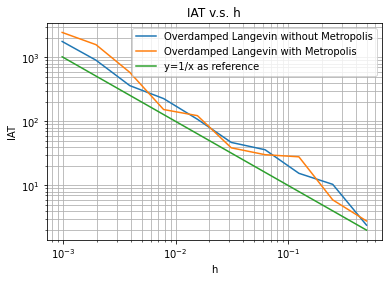

In [5]:
# IAT v.s. h
plt.plot(h_list, IAT1, label = "Overdamped Langevin without Metropolis")
plt.plot(h_list, IAT2, label = "Overdamped Langevin with Metropolis")
plt.plot(h_list, 1/np.array(h_list), label = "y=1/x as reference")
plt.xscale('log')
plt.yscale('log')
plt.title('IAT v.s. h')
plt.xlabel('h')
plt.ylabel('IAT')
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.savefig("64h.png")
files.download("64h.png")
plt.show()

In [6]:
# change lattice size L

beta = 0.1
L_list = [2**i for i in range(1, 11)]
h = 10**(-1)
IAT3 = [] # store IAT without Metropolis when changing L
IAT4 = [] # store IAT with Metropolis when changing L

for L in tqdm.tqdm(L_list):
  a_his3 = OD_langevin(L, beta, h)
  IAT3.append(emcee.autocorr.integrated_time(a_his3, quiet=True))
  a_his4 = OD_langevin(L, beta, h, metro=True)
  IAT4.append(emcee.autocorr.integrated_time(a_his4, quiet=True))

 30%|███       | 3/10 [00:05<00:14,  2.02s/it]<ipython-input-3-90e6d88666aa>:29: RuntimeWarning: invalid value encountered in double_scalars
  p_acc = prob(theta, theta_new, h, beta)*pi(theta_new, beta)/(prob(theta_new, theta, h, beta)*pi(theta, beta))
100%|██████████| 10/10 [04:33<00:00, 27.35s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

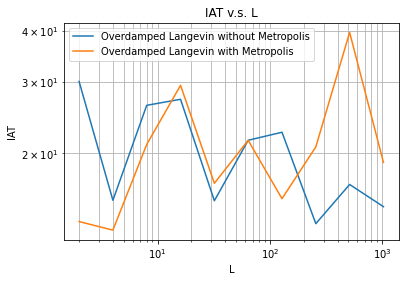

In [7]:
# IAT v.s. L
plt.plot(L_list, IAT3, label = "Overdamped Langevin without Metropolis")
plt.plot(L_list, IAT4, label = "Overdamped Langevin with Metropolis")
plt.xscale('log')
plt.yscale('log')
plt.title('IAT v.s. L')
plt.xlabel('L')
plt.ylabel('IAT')
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.savefig("64L.png")
files.download("64L.png")
plt.show()

**65**

In [12]:
# Hybrid_MC with K(y) = y^2/2, J_hat = identity

def hybrid_metropolis(x, y, x_new, y_new, beta):
  p_acc = (pi(x_new,beta)*np.exp(-np.sum(y_new**2)/2))/(pi(x,beta)*np.exp(-np.sum(y**2)/2))
  return np.random.random() < min(1, p_acc)

def hybrid_MC(L, beta, h, n = 5, metro = False):
  step = int(divmod(500,h)[0])
  a_his = [] # store target functional
  x = np.random.rand(L)*2*np.pi-np.pi # initialize the theta as row vector of length L
  for st in range(step):
    y = np.random.normal(size=L)
    x_new, y_new = deepcopy(x), deepcopy(y)
    for _ in range(n):
      y_new += (h/2)*grad_log_pi(x_new, beta)
      x_new += h*y_new
      y_new += (h/2)*grad_log_pi(x_new, beta)
    if metro == True:
      if hybrid_metropolis(x, y, x_new, y_new, beta): #accept the proposal
        x = x_new
    else:
      x = x_new
    a = np.sum(np.array([np.cos(x), np.sin(x)]), axis=1)
    a_his.append(a[0]/np.linalg.norm(a))
  return a_his # return the history of functional value

In [13]:
# change step size h

h_list = [2**(-i) for i in range(1, 11)]
beta = 0.1
L = 10
IAT5 = [] # store IAT without Metropolis when changing h
IAT6 = [] # store IAT with Metropolis when changing h
for h in tqdm.tqdm(h_list):
  a_his5 = hybrid_MC(L, beta, h, metro = False)
  IAT5.append(emcee.autocorr.integrated_time(a_his5, quiet=True))
  a_his6 = hybrid_MC(L, beta, h, metro = True)
  IAT6.append(emcee.autocorr.integrated_time(a_his6, quiet=True))

 50%|█████     | 5/10 [00:34<00:47,  9.59s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 640;
tau: [808.13572686]
 60%|██████    | 6/10 [01:08<01:11, 17.99s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1280;
tau: [1966.96655172]
 70%|███████   | 7/10 [02:15<01:41, 33.87s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2560;
tau: [8664.32813651]
 80%|████████  | 8/10 [04:29<02:11, 65.78s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 5120;
tau: [21739.73075062]
N/50 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

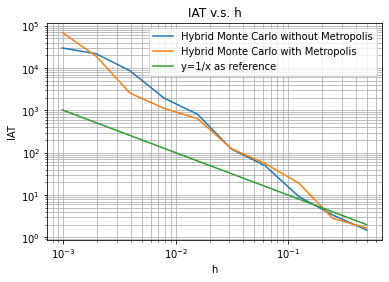

In [17]:
# IAT v.s. h
plt.plot(h_list, IAT5, label = "Hybrid Monte Carlo without Metropolis")
plt.plot(h_list, IAT6, label = "Hybrid Monte Carlo with Metropolis")
plt.plot(h_list, 1/np.array(h_list), label = "y=1/x as reference")
plt.xscale('log')
plt.yscale('log')
plt.title('IAT v.s. h')
plt.xlabel('h')
plt.ylabel('IAT')
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.savefig("65h.png")
files.download("65h.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

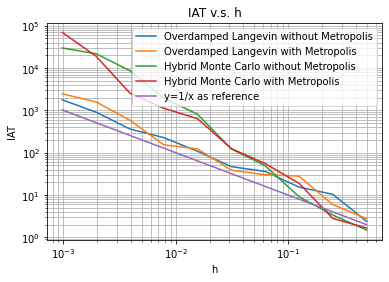

In [18]:
# IAT v.s. h
plt.plot(h_list, IAT1, label = "Overdamped Langevin without Metropolis")
plt.plot(h_list, IAT2, label = "Overdamped Langevin with Metropolis")
plt.plot(h_list, IAT5, label = "Hybrid Monte Carlo without Metropolis")
plt.plot(h_list, IAT6, label = "Hybrid Monte Carlo with Metropolis")
plt.plot(h_list, 1/np.array(h_list), label = "y=1/x as reference")
plt.xscale('log')
plt.yscale('log')
plt.title('IAT v.s. h')
plt.xlabel('h')
plt.ylabel('IAT')
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.savefig("65hh.png")
files.download("65hh.png")
plt.show()

In [19]:
# K(y) = y^2/2, J_hat = identity

def hybrid_pi(x, y, beta):
  return pi(x,beta)*np.exp(-np.sum(y**2)/2)

def UD_metropolis(x, y, x_new, y_new, beta, gamma):
  p_acc = (hybrid_pi(x_new, y_new, beta)*r(x_new, -y_new, x, -y, gamma, h))/(hybrid_pi(x, y, beta)*r(x, y, x_new, y_new, gamma, h)+10**(-10))
  return np.random.random() < min(1, p_acc)

def r(x, y, x_new, y_new, gamma, h):
  den = y_new - np.exp(-gamma*h)*y -(h/2)*(np.exp(-gamma*h)*grad_log_pi(x, beta)+grad_log_pi(x_new, beta))
  power = -np.linalg.norm(den)**2/(2*(1-np.exp(-2*gamma*h)+10**(-10)))
  return np.exp(power)

def UD_langevin(L, beta, gamma, h, metro = False):
  step = int(divmod(500,h)[0])
  a_his = [] # store target functional
  x = np.random.rand(L)*2*np.pi-np.pi # initialize the theta as row vector of length L
  y = np.random.normal(size = L)
  for _ in range(step):
    x_new, y_new = deepcopy(x), deepcopy(y)
    y_new += (h/2)*grad_log_pi(x_new, beta)
    x_new += (h/2)*y_new
    xi = np.random.randint(0,2, len(y))*2-1
    y_new = np.exp(-gamma*h)*y_new + np.sqrt(1-np.exp(-2*gamma*h)+10**(-10))*xi
    x_new += (h/2)*y_new
    y_new += (h/2)*grad_log_pi(x_new, beta)
    if metro == True:
      if UD_metropolis(x, y, x_new, y_new, beta, gamma): #accept the proposal
        x, y = x_new, y_new
      else:
        x, y = x, -y
    else:
      x, y = x_new, y_new
    a = np.sum(np.array([np.cos(x), np.sin(x)]), axis=1)
    a_his.append(a[0]/np.linalg.norm(a))
  return a_his # return the history of functional value

In [20]:
h_list = [2**(-i) for i in range(1, 11)]
beta = 0.1
L = 10
gamma = 1
IAT7 = [] # store IAT without Metropolis when changing h
IAT8 = [] # store IAT with Metropolis when changing h

for h in tqdm.tqdm(h_list):
  a_his7 = UD_langevin(L, beta, gamma, h)
  IAT7.append(emcee.autocorr.integrated_time(a_his7, quiet=True))
  a_his8 = UD_langevin(L, beta, gamma, h, metro = True)
  IAT8.append(emcee.autocorr.integrated_time(a_his8, quiet=True))

100%|██████████| 10/10 [11:35<00:00, 69.50s/it] 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

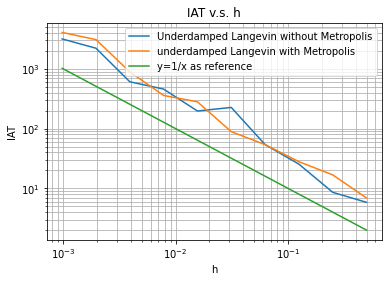

In [22]:
# IAT v.s. h
plt.plot(h_list, IAT7, label = "Underdamped Langevin without Metropolis")
plt.plot(h_list, IAT8, label = "underdamped Langevin with Metropolis")
plt.plot(h_list, 1/np.array(h_list), label = "y=1/x as reference")
plt.xscale('log')
plt.yscale('log')
plt.title('IAT v.s. h')
plt.xlabel('h')
plt.ylabel('IAT')
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.savefig("66h.png")
files.download("66h.png")
plt.show()

In [23]:
gamma_list = [0.1*i for i in range(51)]
beta = 0.1
L = 10
h = 10**(-1)
IAT9 = [] # store IAT without Metropolis when changing gamma
IAT10 = [] # store IAT with Metropolis when changing gamma

for gamma in tqdm.tqdm(gamma_list):
  a_his = UD_langevin(L, beta, gamma, h)
  IAT9.append(emcee.autocorr.integrated_time(a_his, quiet=True))
  a_his = UD_langevin(L, beta, gamma, h, metro = True)
  IAT10.append(emcee.autocorr.integrated_time(a_his, quiet=True))

 57%|█████▋    | 29/51 [01:44<01:26,  3.92s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [128.9440754]
 67%|██████▋   | 34/51 [02:01<01:01,  3.60s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [123.34079971]
 69%|██████▊   | 35/51 [02:05<00:56,  3.55s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [126.31746722]
 78%|███████▊  | 40/51 [02:26<00:45,  4.14s/it]WARNING:emcee.autocorr:The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [145.66938957]
 82%|████

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

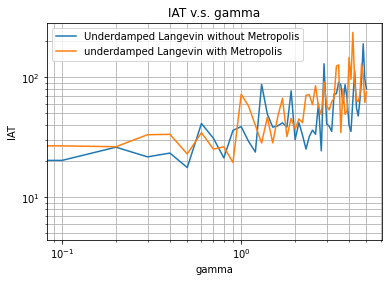

In [24]:
# IAT v.s. gamma
plt.plot(gamma_list, IAT9, label = "Underdamped Langevin without Metropolis")
plt.plot(gamma_list, IAT10, label = "underdamped Langevin with Metropolis")
plt.xscale('log')
plt.yscale('log')
plt.title('IAT v.s. gamma')
plt.xlabel('gamma')
plt.ylabel('IAT')
plt.grid(visible=True, which='both', axis='both')
plt.legend()
plt.savefig("66g.png")
files.download("66g.png")
plt.show()